In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
gmsh.initialize()
# gmsh.option.setNumber("Mesh.SecondOrderLinear", 1)
# 如果你在生成高阶网格时需要禁用物面弯曲,需要打开这个选项.注意jupyter里修改gmsh.option的值不会立即生效,需要重启gmsh.你可以使用gmsh.finalize()关闭gmsh,然后再重新初始化gmsh,也可以直接重启kernal.
info = gmsh.option.getString("General.BuildInfo")
for line in info.split("; "):
    print(line.strip())

def print_array(array):
    print(array)
    print(array.shape)

Version: 4.11.1
License: GNU General Public License
Build OS: MacOSARM-sdk
Build date: 20231113
Build host: Mac-1699840872433.local
Build options: 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blossom Cairo DIntegration Dlopen DomHex Eigen[contrib] Fltk GMP Gmm[contrib] Hxt Jpeg Kbipack MathEx[contrib] Mesh Metis[contrib] Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version: 1.3.8
OCC version: 7.7.2
Packaged by: runner
Web site: https://gmsh.info
Issue tracker: https://gitlab.onelab.info/gmsh/gmsh/issues


In [2]:
# 这里我们先生成一个简单的带有边界弯曲的三角四边混合网格

mesh_order = 2

gmsh.clear()
gmsh.model.add("test")
gmsh.model.occ.addPoint(-1, 0, 0, 1, 1)
gmsh.model.occ.addPoint(0, 0, 0, 1, 2)
gmsh.model.occ.addPoint(1, 0, 0, 1, 3)
gmsh.model.occ.addPoint(0, 1, 0, 1, 4)
gmsh.model.occ.addLine(1, 2, 1)
gmsh.model.occ.addLine(2, 3, 2)
gmsh.model.occ.addLine(2, 4, 3)
gmsh.model.occ.addCircleArc(3, 2, 4)
gmsh.model.occ.addCircleArc(4, 2, 1)
gmsh.model.occ.addCurveLoop([1, 3, 5], 1)
gmsh.model.occ.addPlaneSurface([1], 1)
gmsh.model.occ.addCurveLoop([2, 4, -3], 2)
gmsh.model.occ.addPlaneSurface([2], 2)
gmsh.model.occ.synchronize()
gmsh.model.addPhysicalGroup(1, [1, 2], name="bc-1")
gmsh.model.addPhysicalGroup(1, [4, 5], name="bc-2")
gmsh.model.addPhysicalGroup(2, [1], name="vc-1")
gmsh.model.addPhysicalGroup(2, [2], name="vc-2")
gmsh.model.mesh.setRecombine(2, 2)
gmsh.model.mesh.generate(2)
gmsh.model.mesh.setOrder(mesh_order)
gmsh.model.mesh.optimize("HighOrderElastic")

# gmsh.fltk.run() # 这里可以查看一下网格的情况

# gmsh.write("test.msh")

# 这里gui上显示的边界弯曲应该是只有三个点构成的两端直线拟合的,但我们网格实际生成的是三阶的,理论上在边界处应该是有四个点,这里两者不相符是由于gmsh的fltk显示问题,如果你把这里的网格用python绘制出来,其实是正确的.gmsh这样操作是为了减少图形化界面在显示这类高阶网格时的计算量,你也可以使用gmsh.option.setNumber("Mesh.NumSubEdges", n)来调整显示的精度,注意这个选项也不会正确的显示阶数,它只会把边界弯曲的点数调整为n+1,无论你目前的网格阶数是多少.

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Circle)
Info    : [ 80%] Meshing curve 5 (Circle)
Info    : Done meshing 1D (Wall 0.0002305s, CPU 0.000277s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 50%] Blossom: 6 internal 6 closed
Info    : [ 50%] Blossom recombination completed (Wall 0.000105042s, CPU 0.000105s): 3 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.666667, min Q = 0.609206
Info    : Done meshing 2D (Wall 0.000745666s, CPU 0.000725s)
Info    : 9 nodes 19 elements
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 20%] Meshing curve 2 order 2
Info    : [ 30%] Meshing curve 3 

In [3]:
# 下面积分信息读入的时候我们就只用三角形举例,四边形同理

In [4]:
# 读取gmsh里有关单元类型的唯一标号,后续在读取单元的时候就会用这个唯一编号来读取单元类型,注意这个编号是和阶数相关的,如果你在生成网格的时候改变了阶数,这里的编号也会随之改变.

line_gmsh_type_number = gmsh.model.mesh.getElementType("Line", mesh_order)
triangle_gmsh_type_number = gmsh.model.mesh.getElementType("Triangle", mesh_order)
quadrangle_gmsh_type_number = gmsh.model.mesh.getElementType("Quadrangle", mesh_order)

line_gmsh_type_number, triangle_gmsh_type_number, quadrangle_gmsh_type_number

(8, 9, 10)

In [5]:
# 从gmsh里提取Guass积分点的坐标和权重,这里的坐标是在参考单元上的坐标,权重是在参考单元上的权重,这里的权重是已经乘上了参考单元的面积的,所以在后续计算积分的时候不需要再乘上参考单元的面积了.

# 注意这里给出积分点需要的输入是Gauss积分的精度,也就是所能满足的完全多项式的最高阶数,而不是积分点的个数,积分点的个数是和阶数相关的,具体请查看gmsh的文档.

triangle_gauss_quadrature_local_coordinates, triangle_gauss_quadrature_weights = gmsh.model.mesh.getIntegrationPoints(triangle_gmsh_type_number, f"Gauss{2*mesh_order}")

triangle_gauss_quadrature_points_number = int(triangle_gauss_quadrature_local_coordinates.shape[0] / 3)

print_array(triangle_gauss_quadrature_local_coordinates.reshape(triangle_gauss_quadrature_points_number, 3))

[[0.44594849 0.44594849 0.        ]
 [0.44594849 0.10810302 0.        ]
 [0.10810302 0.44594849 0.        ]
 [0.09157621 0.09157621 0.        ]
 [0.09157621 0.81684757 0.        ]
 [0.81684757 0.09157621 0.        ]]
(6, 3)


In [6]:
# 有了积分点信息,我们就可以从gmsh里导出各积分点上的基函数信息,这里导出的基函数信息并不是解析的,而是在积分点上的基函数值,也就是说这里的信息都是有关局部坐标的.

_, triangle_basis_functions, _ = gmsh.model.mesh.getBasisFunctions(triangle_gmsh_type_number, triangle_gauss_quadrature_local_coordinates, f"Lagrange{mesh_order}")

triangle_basis_functions_number = int(triangle_basis_functions.shape[0] / triangle_gauss_quadrature_points_number)

print_array(triangle_basis_functions.reshape(triangle_gauss_quadrature_points_number, triangle_basis_functions_number))

[[-0.08473049 -0.04820838 -0.04820838  0.19283351  0.79548023  0.19283351]
 [-0.04820838 -0.04820838 -0.08473049  0.79548023  0.19283351  0.19283351]
 [-0.04820838 -0.08473049 -0.04820838  0.19283351  0.19283351  0.79548023]
 [ 0.51763234 -0.07480381 -0.07480381  0.29921523  0.03354481  0.29921523]
 [-0.07480381 -0.07480381  0.51763234  0.03354481  0.29921523  0.29921523]
 [-0.07480381  0.51763234 -0.07480381  0.29921523  0.29921523  0.03354481]]
(6, 6)


In [7]:
# 读取基函数的导数的值,这里理论上说就是一个张量了.

_, triangle_grad_basis_functions, _ = gmsh.model.mesh.getBasisFunctions(triangle_gmsh_type_number, triangle_gauss_quadrature_local_coordinates, f"GradLagrange{mesh_order}")

print_array(triangle_grad_basis_functions.reshape(triangle_gauss_quadrature_points_number, triangle_basis_functions_number, 3))

[[[ 5.67587927e-01  5.67587927e-01  0.00000000e+00]
  [ 7.83793964e-01  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  7.83793964e-01  0.00000000e+00]
  [-1.35138189e+00 -1.78379396e+00  0.00000000e+00]
  [ 1.78379396e+00  1.78379396e+00  0.00000000e+00]
  [-1.78379396e+00 -1.35138189e+00  0.00000000e+00]]

 [[-7.83793964e-01 -7.83793964e-01  0.00000000e+00]
  [ 7.83793964e-01  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -5.67587927e-01  0.00000000e+00]
  [ 0.00000000e+00 -1.78379396e+00  0.00000000e+00]
  [ 4.32412073e-01  1.78379396e+00  0.00000000e+00]
  [-4.32412073e-01  1.35138189e+00  0.00000000e+00]]

 [[-7.83793964e-01 -7.83793964e-01  0.00000000e+00]
  [-5.67587927e-01  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  7.83793964e-01  0.00000000e+00]
  [ 1.35138189e+00 -4.32412073e-01  0.00000000e+00]
  [ 1.78379396e+00  4.32412073e-01  0.00000000e+00]
  [-1.78379396e+00  0.00000000e+00  0.00000000e+00]]

 [[-2.26739029e+00 -2.26739029e+00  0.00000000e+00]
  [-6.

In [8]:
# 从gmsh里插值读取单元边界上的基函数在积分点处的值,这里情况会比较复杂,需要进行一部分的插值,先把边界单元的积分信息读取出来.注意在边界处的精度要求是2*mesh_order+1

line_gauss_quadrature_local_coordinates, line_gauss_quadrature_weights = gmsh.model.mesh.getIntegrationPoints(line_gmsh_type_number, f"Gauss{2*mesh_order+1}")

line_gauss_quadrature_points_number = int(line_gauss_quadrature_local_coordinates.shape[0] / 3)

# 这里我们用坐标变换的方式来获取单元边界上的积分点坐标,一阶的变换就可以满足要求了,因为在这里我们变换的目标是标准单元,它是不需要被弯曲的

_, line_basis_functions, _ = gmsh.model.mesh.getBasisFunctions(line_gmsh_type_number, line_gauss_quadrature_local_coordinates, f"Lagrange1")

line_basis_functions_number = int(line_basis_functions.shape[0] / line_gauss_quadrature_points_number)

print_array(line_basis_functions.reshape(line_gauss_quadrature_points_number, line_basis_functions_number))

[[0.88729833 0.11270167]
 [0.5        0.5       ]
 [0.11270167 0.88729833]]
(3, 2)


In [9]:
# 有了上面基函数的值,我们用一阶的坐标变换的方式就可以获得单元边界上的积分点坐标

triangle_adjacency_number = 3

triangle_standard_coordinates = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0]])

triangle_adjacency_gauss_quadrature_local_coordinates = np.zeros((triangle_adjacency_number, line_gauss_quadrature_points_number, 3))

for i in range(triangle_adjacency_number):
    for j in range(line_gauss_quadrature_points_number):
        triangle_adjacency_gauss_quadrature_local_coordinates[i, j] = triangle_standard_coordinates[i] * line_basis_functions[line_basis_functions_number * j] + triangle_standard_coordinates[(i + 1) % triangle_adjacency_number] * line_basis_functions[line_basis_functions_number * j + 1]

triangle_adjacency_gauss_quadrature_local_coordinates = triangle_adjacency_gauss_quadrature_local_coordinates.reshape(-1)

triangle_adjacency_gauss_quadrature_points_number = triangle_adjacency_number * line_gauss_quadrature_points_number

print_array(triangle_adjacency_gauss_quadrature_local_coordinates.reshape(triangle_adjacency_gauss_quadrature_points_number, 3))

[[0.11270167 0.         0.        ]
 [0.5        0.         0.        ]
 [0.88729833 0.         0.        ]
 [0.88729833 0.11270167 0.        ]
 [0.5        0.5        0.        ]
 [0.11270167 0.88729833 0.        ]
 [0.         0.88729833 0.        ]
 [0.         0.5        0.        ]
 [0.         0.11270167 0.        ]]
(9, 3)


In [10]:
# 这样就可以从gmsh里导出在这些积分点上基函数的值了,这里只需要基函数的值,导数其实是不需要的

_, triangle_adjacency_basis_functions, _ = gmsh.model.mesh.getBasisFunctions(triangle_gmsh_type_number, triangle_adjacency_gauss_quadrature_local_coordinates, f"Lagrange{mesh_order}")

print_array(triangle_adjacency_basis_functions.reshape(triangle_adjacency_gauss_quadrature_points_number, triangle_basis_functions_number))

[[ 6.87298335e-01 -8.72983346e-02  0.00000000e+00  4.00000000e-01
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.72983346e-02  6.87298335e-01  0.00000000e+00  4.00000000e-01
   0.00000000e+00  0.00000000e+00]
 [-3.88578059e-16  6.87298335e-01 -8.72983346e-02 -5.55111512e-17
   4.00000000e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -8.72983346e-02  6.87298335e-01  0.00000000e+00
   4.00000000e-01  0.00000000e+00]
 [-8.72983346e-02  0.00000000e+00  6.87298335e-01  0.00000000e+00
   0.00000000e+00  4.00000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 6.87298335e-01  0.00000000e+00 -8.72983346e-02  0.00000000e+00
   0.00000000e+00  4.00000000e-01]]
(9, 6)


In [11]:
# 接下来读取网格信息,我们先把网格里所有的node读取出来,这里的node是按照编号顺序排列的,理论上这个顺序是排好的,但以防万一我们还是把它们按照编号重新排列一下

node_tags, node_coordinates_, _ = gmsh.model.mesh.getNodes()

node_coordinates = np.zeros((node_tags.shape[0], 3))

for i in range(node_tags.shape[0]):
    node_coordinates[int(node_tags[i] - 1),:] = node_coordinates_[3 * i:3 * i + 3]

print_array(node_coordinates)

[[-1.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 0.          1.          0.        ]
 [-0.5         0.          0.        ]
 [ 0.5         0.          0.        ]
 [ 0.25        0.          0.        ]
 [ 0.75        0.          0.        ]
 [ 0.          0.5         0.        ]
 [ 0.          0.25        0.        ]
 [ 0.          0.75        0.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.92387953  0.38268343  0.        ]
 [ 0.38268343  0.92387953  0.        ]
 [-0.70710678  0.70710678  0.        ]
 [-0.38268343  0.92387953  0.        ]
 [-0.92387953  0.38268343  0.        ]
 [-0.35355339  0.60355339  0.        ]
 [-0.35355339  0.35355339  0.        ]
 [ 0.37966661  0.37966661  0.        ]
 [ 0.1898333   0.4398333   0.        ]
 [ 0.54338669  0.54338669  0.        ]
 [ 0.28625837  0.68185642  0.        ]
 [ 0.4398333   0.1898333   0.        ]
 [ 0.68185642  0.28625837  0.        ]
 [ 0.21991665  0.21991665

In [12]:
# 让后读取每种类型的单元信息,这里包含每个单元所包含的节点编号以及坐标,以及每个单元的唯一编号

triangle_tags, triangle_node_tags = gmsh.model.mesh.getElementsByType(triangle_gmsh_type_number)

triangle_number = triangle_tags.shape[0]

triangle_per_element_node_number = int((mesh_order + 1) * (mesh_order + 2) / 2)

triangle_node_coordinates = np.zeros((triangle_number, triangle_per_element_node_number, 3))

for i in range(triangle_number):
    for j in range(triangle_per_element_node_number):
        triangle_node_coordinates[i, j] = node_coordinates[int(triangle_node_tags[triangle_per_element_node_number * i + j] - 1)]

print_array(triangle_node_coordinates)

[[[-0.70710678  0.70710678  0.        ]
  [ 0.          0.5         0.        ]
  [ 0.          1.          0.        ]
  [-0.35355339  0.60355339  0.        ]
  [ 0.          0.75        0.        ]
  [-0.38268343  0.92387953  0.        ]]

 [[-0.70710678  0.70710678  0.        ]
  [-1.          0.          0.        ]
  [ 0.          0.          0.        ]
  [-0.92387953  0.38268343  0.        ]
  [-0.5         0.          0.        ]
  [-0.35355339  0.35355339  0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.5         0.        ]
  [-0.70710678  0.70710678  0.        ]
  [ 0.          0.25        0.        ]
  [-0.35355339  0.60355339  0.        ]
  [-0.35355339  0.35355339  0.        ]]]
(3, 6, 3)


In [13]:
# 接下来我们通过gmsh内置的函数来读取jacobian,局部坐标选用单元的积分点坐标

triangle_jacobians_, triangle_jacobian_determinants_, _ = gmsh.model.mesh.getJacobians(triangle_gmsh_type_number, triangle_gauss_quadrature_local_coordinates)

triangle_jacobians = np.zeros((triangle_number, triangle_gauss_quadrature_points_number, 3, 3))

triangle_jacobian_determinants = np.zeros((triangle_number, triangle_gauss_quadrature_points_number))

for i in range(triangle_number):
    for j in range(triangle_gauss_quadrature_points_number):
        triangle_jacobians[i, j] = np.resize(triangle_jacobians_[i * triangle_gauss_quadrature_points_number * 9 + j * 9 : i * triangle_gauss_quadrature_points_number * 9 + (j + 1) * 9], (3,3))
        triangle_jacobian_determinants[i, j] = triangle_jacobian_determinants_[i * triangle_gauss_quadrature_points_number + j]

print_array(triangle_jacobian_determinants)


[[0.39842866 0.43779447 0.45747738 0.50165745 0.41714871 0.37489434]
 [0.77166496 0.81103077 0.77166496 0.81295647 0.72844773 0.81295647]
 [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339]]
(3, 6)


In [14]:
# 接着我们应该重构单元的链接信息了,在此之前,我们先把四边形单元的节点编号都读出来

quadrangle_tags, quadrangle_node_tags = gmsh.model.mesh.getElementsByType(quadrangle_gmsh_type_number)

quadrangle_number = quadrangle_tags.shape[0]

quadrangle_per_element_node_number = int((mesh_order + 1) * (mesh_order + 1))

quadrangle_node_coordinates = np.zeros((quadrangle_number, quadrangle_per_element_node_number, 3))

for i in range(quadrangle_number):
    for j in range(quadrangle_per_element_node_number):
        quadrangle_node_coordinates[i, j] = node_coordinates[int(quadrangle_node_tags[quadrangle_per_element_node_number * i + j] - 1)]

print_array(quadrangle_node_coordinates)

[[[0.         0.5        0.        ]
  [0.37966661 0.37966661 0.        ]
  [0.70710678 0.70710678 0.        ]
  [0.         1.         0.        ]
  [0.1898333  0.4398333  0.        ]
  [0.54338669 0.54338669 0.        ]
  [0.38268343 0.92387953 0.        ]
  [0.         0.75       0.        ]
  [0.28625837 0.68185642 0.        ]]

 [[0.5        0.         0.        ]
  [1.         0.         0.        ]
  [0.70710678 0.70710678 0.        ]
  [0.37966661 0.37966661 0.        ]
  [0.75       0.         0.        ]
  [0.92387953 0.38268343 0.        ]
  [0.54338669 0.54338669 0.        ]
  [0.4398333  0.1898333  0.        ]
  [0.68185642 0.28625837 0.        ]]

 [[0.5        0.         0.        ]
  [0.37966661 0.37966661 0.        ]
  [0.         0.5        0.        ]
  [0.         0.         0.        ]
  [0.4398333  0.1898333  0.        ]
  [0.1898333  0.4398333  0.        ]
  [0.         0.25       0.        ]
  [0.25       0.         0.        ]
  [0.21991665 0.21991665 0.       

In [15]:
# 先开一个class来存储信息

class AdjacencyElementMeshSupplemental:

    def __init__(self):
        self.is_recorded_ = False
        self.node_tags_ = []
        self.parent_index_ = []
        self.adjacency_sequence_ = []
        self.parent_gmsh_type_number_ = []

    def __str__(self):
        return f"is_recorded_:{self.is_recorded_} node_tags_: {self.node_tags_} parent_index_: {self.parent_index_} adjacency_sequence_: {self.adjacency_sequence_} parent_gmsh_type_number_: {self.parent_gmsh_type_number_}"

adjacency_element_dict = {}

In [16]:
# 这里首先要让gmsh生成边的信息,注意尽管如此gmsh中并没有内边的唯一tag

gmsh.model.mesh.createEdges()

line_per_element_node_number = int(mesh_order + 1)

# 然后我们就可以读取边的信息了,注意这个函数读取出来的边的节点号是高阶的,这个函数的意思就是对这一类单元,按顺序把每个单元的边的节点号都读出来.

triangle_high_order_edge_node_tags = gmsh.model.mesh.getElementEdgeNodes(triangle_gmsh_type_number)

triangle_all_line_number = int(triangle_high_order_edge_node_tags.shape[0] / line_per_element_node_number)

# 我们只保留一阶单元的编号,也就是Line的端点

triangle_normal_edge_node_tags = np.zeros((triangle_all_line_number, 2))

for i in range(triangle_all_line_number):
    triangle_normal_edge_node_tags[i] = triangle_high_order_edge_node_tags[i * line_per_element_node_number : i * line_per_element_node_number + 2]

triangle_normal_edge_node_tags_ = triangle_normal_edge_node_tags.reshape(-1)

print_array(triangle_normal_edge_node_tags)

[[15.  9.]
 [ 9.  4.]
 [ 4. 15.]
 [15.  1.]
 [ 1.  2.]
 [ 2. 15.]
 [ 2.  9.]
 [ 9. 15.]
 [15.  2.]]
(9, 2)


In [17]:
# 有了这些边的端点号,我们利用这个端点号来反向寻找端点是这两个点的边的唯一编号

triangle_edge_tags, _ = gmsh.model.mesh.getEdges(triangle_normal_edge_node_tags_)

print_array(triangle_edge_tags)

[10  5  8  9  1 11  4 10 11]
(9,)


In [18]:
# 我们还需要相对应的单元编号,这里其实上面已经读过一次了,但这里再读一次因为这一部分信息其实大概率是没保存的

triangle_tags, triangle_node_tags = gmsh.model.mesh.getElementsByType(triangle_gmsh_type_number)

print_array(triangle_tags)

[ 8  9 10]
(3,)


In [19]:
# 这三部分信息读完,就可以开始填充这里这个dict了,这里主要的思路就是利用边是按照单元并且是逆时针的顺序排列的这一特点,按顺序把每条边填充进dict中,如果发现这个key已经出现过,那么就说明这条边是一条内边.

for i in range(triangle_all_line_number):
    if triangle_edge_tags[i] not in adjacency_element_dict:
        adjacency_element_dict[triangle_edge_tags[i]] = AdjacencyElementMeshSupplemental()
        for j in range(line_per_element_node_number):
            adjacency_element_dict[triangle_edge_tags[i]].node_tags_.append(triangle_high_order_edge_node_tags[i * line_per_element_node_number + j])
        adjacency_element_dict[triangle_edge_tags[i]].is_recorded_ = False
    else:
        adjacency_element_dict[triangle_edge_tags[i]].is_recorded_ = True
    adjacency_element_dict[triangle_edge_tags[i]].parent_index_.append(triangle_tags[int(i / triangle_adjacency_number)] - triangle_tags[0])
    adjacency_element_dict[triangle_edge_tags[i]].adjacency_sequence_.append(i % triangle_adjacency_number)
    adjacency_element_dict[triangle_edge_tags[i]].parent_gmsh_type_number_.append(triangle_gmsh_type_number)

print(adjacency_element_dict[10])

is_recorded_:True node_tags_: [15, 9, 18] parent_index_: [0, 2] adjacency_sequence_: [0, 1] parent_gmsh_type_number_: [9, 9]


In [20]:
# 由于这里是混合网格,单独三角形的边界信息并不够,因此我们在四边形上重复上面这个程序

quadrangle_adjacency_number = 4

quadrangle_high_order_edge_node_tags = gmsh.model.mesh.getElementEdgeNodes(quadrangle_gmsh_type_number)

quadrangle_all_line_number = int(quadrangle_high_order_edge_node_tags.shape[0] / line_per_element_node_number)

quadrangle_normal_edge_node_tags = np.zeros((quadrangle_all_line_number, 2))

for i in range(quadrangle_all_line_number):
    quadrangle_normal_edge_node_tags[i] = quadrangle_high_order_edge_node_tags[i * line_per_element_node_number : i * line_per_element_node_number + 2]

quadrangle_normal_edge_node_tags_ = quadrangle_normal_edge_node_tags.reshape(-1)

quadrangle_edge_tags, _ = gmsh.model.mesh.getEdges(quadrangle_normal_edge_node_tags_)

quadrangle_tags, quadrangle_node_tags = gmsh.model.mesh.getElementsByType(quadrangle_gmsh_type_number)

for i in range(quadrangle_all_line_number):
    if quadrangle_edge_tags[i] not in adjacency_element_dict:
        adjacency_element_dict[quadrangle_edge_tags[i]] = AdjacencyElementMeshSupplemental()
        for j in range(line_per_element_node_number):
            adjacency_element_dict[quadrangle_edge_tags[i]].node_tags_.append(quadrangle_high_order_edge_node_tags[i * line_per_element_node_number + j])
        adjacency_element_dict[quadrangle_edge_tags[i]].is_recorded_ = False
    else:
        adjacency_element_dict[quadrangle_edge_tags[i]].is_recorded_ = True
    adjacency_element_dict[quadrangle_edge_tags[i]].parent_index_.append(quadrangle_tags[int(i / quadrangle_adjacency_number)] - quadrangle_tags[0])
    adjacency_element_dict[quadrangle_edge_tags[i]].adjacency_sequence_.append(i % quadrangle_adjacency_number)
    adjacency_element_dict[quadrangle_edge_tags[i]].parent_gmsh_type_number_.append(quadrangle_gmsh_type_number)

print(adjacency_element_dict[5])

is_recorded_:True node_tags_: [9, 4, 11] parent_index_: [0, 0] adjacency_sequence_: [1, 3] parent_gmsh_type_number_: [9, 10]


In [21]:
# 接下来利用这个dict我们就能把内边以及外边的信息给区分开来了,这里我们先把内边和外边的edge_tag给分出来.由于这些边我们是需要它的jacobian的,但是在gmsh里想要获取单元jacobian是需要有单元全局编号的,而我们上面获得的编号只是有关边的一个唯一编号,这个编号是从1开始的,因此我们需要把这些边手动添加成单元.其实这里对于外边界来说其本身是具有唯一编号的,但是和这里的编号并不是一样的,但是我们又不能同样添加,这样会导致后面的PhysicalGroup的编号混乱,因此我们只添加内边的编号,外边的编号我们会用node_tag遍历的方式来进行添加.

interior_edge_tags = []
interior_edge_node_tags = []
boundary_edge_tags = []
boundary_edge_node_tags = []

for key in adjacency_element_dict:
    if adjacency_element_dict[key].is_recorded_:
        interior_edge_tags.append(key)
        interior_edge_node_tags.extend(adjacency_element_dict[key].node_tags_)
    else:
        boundary_edge_tags.append(key)
        boundary_edge_node_tags.extend(adjacency_element_dict[key].node_tags_)

print_array(np.array(boundary_edge_tags))

[8 9 1 7 3 6 2]
(7,)


In [22]:
# 接下来我们还需要一个边界单元与全局唯一单元编号的映射表,这里我们只能通过逐一对比node_tag来获取了,因为gmsh里没有"""getElementsByNodes"""这样的函数.

boundary_edge_global_tags = []

boundary_edge_all_tags, boundary_edge_all_node_tags_ = gmsh.model.mesh.getElementsByType(line_gmsh_type_number)

boundary_edge_all_node_tags = np.array(boundary_edge_all_node_tags_).reshape(-1, 3)

boundary_edge_all_tags_map = {}

# 并且注意这里有可能节点顺序不一样,所以用hash表的时候要注意一下
for i in range(boundary_edge_all_tags.shape[0]):
    boundary_edge_all_tags_map[frozenset({boundary_edge_all_node_tags[i][0], boundary_edge_all_node_tags[i][1]})] = boundary_edge_all_tags[i]

# 这里我们只需要比较单元的基础节点就可以了,高阶节点可以不计入比较,
for i in boundary_edge_tags:
    boundary_edge_global_tags.append(boundary_edge_all_tags_map[frozenset({adjacency_element_dict[i].node_tags_[0], adjacency_element_dict[i].node_tags_[1]})])

boundary_edge_global_tags

[6, 7, 1, 5, 3, 4, 2]

In [23]:
# 注意这里搜索内边最好放在boundary之后执行,这样添加进去的新边就不会在上一步中被检索.

# 这里拿到最大单元编号,后面所有的单元就往后加
max_element_tag = gmsh.model.mesh.getMaxElementTag()

# 新建一个离散实体,等会边就添加到这个实体里
entity_tag = gmsh.model.addDiscreteEntity(1)

interior_edge_global_tags = range(max_element_tag + 1, max_element_tag + 1 + len(interior_edge_tags))

gmsh.model.mesh.addElementsByType(entity_tag, line_gmsh_type_number, interior_edge_global_tags, interior_edge_node_tags)

print_array(np.array(interior_edge_global_tags))

[66 67 68 69 70 71 72]
(7,)


In [24]:
# 现在你有了内部以及边界的边的信息,这里对于内部边,我们正常存储上述信息即可,对于边界边,我们还要使用gmsh的PhysicalGroup信息来确定这条边界是一条什么边界,我们的目标就是获得一个有关PhysicalGroup和边的唯一tag的对应信息,这样我们就可以确定这条边界是一条什么边界了.

# 首先我们读取所有的PhysicalGroup信息,也就是唯一的tag,这里会有一维和二维的信息,这没关系,我们都读取进来,因为后续在进行初始流场的时候就是需要二维的tag信息.

physical_group_tags = gmsh.model.getPhysicalGroups()

physical_group_number = len(physical_group_tags)

physical_group_tags

[(1, 1), (1, 2), (2, 3), (2, 4)]

In [25]:
# 接下来是和PhysicalGroupTag对应的名称

physical_group_names = []

for tag in physical_group_tags:
    physical_group_names.append(gmsh.model.getPhysicalName(tag[0], tag[1]))

physical_group_names

['bc-1', 'bc-2', 'vc-1', 'vc-2']

In [26]:
# 让后的思路无非就是获取只绑定在这个PhysicalGroup上的单元就行了,但是这里我们没有这个叫做"""getElementsByPhysicalGroup"""的函数,gmsh里只提供了getEntitiesForPhysicalGroup这个函数,我们只能先获取绑定在这个PhysicalGroup上的所有实体,然后再从中筛选出单元,这里我们先把所有的实体都读取出来

entity_tags = []

for tag in physical_group_tags:
    entity_tags.append(gmsh.model.getEntitiesForPhysicalGroup(tag[0], tag[1]))

# 我们由此再去获得绑定在这些实体上的单元编号即可

physical_group_element_tags = []

for i in range(physical_group_number):
    physical_group_element_tags.append([])
    for j in entity_tags[i]:
        physical_group_element_tags[i].extend(gmsh.model.mesh.getElements(physical_group_tags[i][0], j)[1][0])

physical_group_element_tags

[[1, 2, 3], [4, 5, 6, 7], [8, 9, 10], [11, 12, 13]]

In [27]:
# 有了上面这个和PhysicalGroup对应的单元编号,无论是边界单元的类型,还是内部单元的类型,都可以对应起来了.最后我们再来搞下内部的边单元的Jacobian,就用上面添加的内部边的全局单元编号.

interior_edge_jacobians_, interior_edge_jacobian_determinants_, _ = gmsh.model.mesh.getJacobian(interior_edge_global_tags[0], line_gauss_quadrature_local_coordinates)

interior_edge_jacobian_determinants_

array([0.36840644, 0.36840644, 0.36840644])

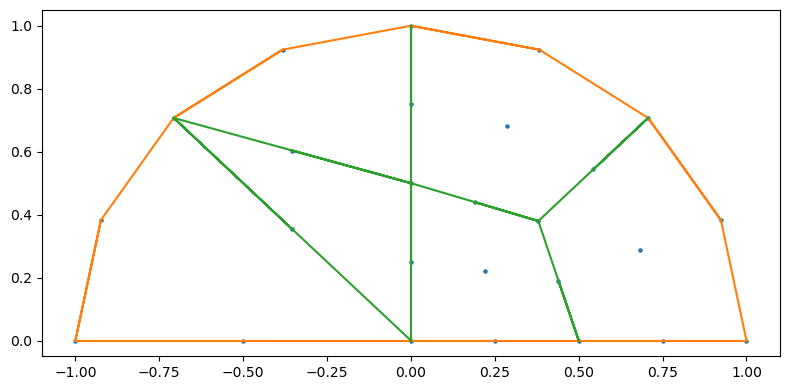

In [28]:
# 最后我们把这个网格图像画出来,这里我们直接绘出全局的网格点,然后再把单元的边画出来,这样就可以了.

boundary_edge_node_coordinates = np.zeros((len(boundary_edge_tags) * 4, 2))
interior_edge_node_coordinates = np.zeros((len(interior_edge_tags) * 4, 2))

for i in range(len(boundary_edge_tags)):
    boundary_edge_node_coordinates[4 * i,:] = node_coordinates[int(boundary_edge_node_tags[i * 3] - 1),:2]
    boundary_edge_node_coordinates[4 * i + 1,:] = node_coordinates[int(boundary_edge_node_tags[i * 3 + 2] - 1),:2]
    boundary_edge_node_coordinates[4 * i + 2,:] = node_coordinates[int(boundary_edge_node_tags[i * 3 + 1] - 1),:2]
    boundary_edge_node_coordinates[4 * i + 3,:] = node_coordinates[int(boundary_edge_node_tags[i * 3 + 2] - 1),:2]

for i in range(len(interior_edge_tags)):
    interior_edge_node_coordinates[4 * i,:] = node_coordinates[int(interior_edge_node_tags[i * 3] - 1),:2]
    interior_edge_node_coordinates[4 * i + 1,:] = node_coordinates[int(interior_edge_node_tags[i * 3 + 1] - 1),:2]
    interior_edge_node_coordinates[4 * i + 2,:] = node_coordinates[int(interior_edge_node_tags[i * 3 + 2] - 1),:2]
    interior_edge_node_coordinates[4 * i + 3,:] = node_coordinates[int(interior_edge_node_tags[i * 3 + 1] - 1),:2]

fig, ax = plt.subplots(figsize=(8, 4))
fig.set_tight_layout(True)
ax.scatter(node_coordinates[:,0], node_coordinates[:,1], s=5, color="C0")
for i in range(len(boundary_edge_tags)):
    ax.plot(boundary_edge_node_coordinates[4 * i:4 * i + 4,0], boundary_edge_node_coordinates[4 * i:4 * i + 4,1], color="C1")
for i in range(len(interior_edge_tags)):
    ax.plot(interior_edge_node_coordinates[4 * i:4 * i + 4,0], interior_edge_node_coordinates[4 * i:4 * i + 4,1], color="C2")